<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-необходимых-библиотек" data-toc-modified-id="Импорт-необходимых-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт необходимых библиотек</a></span></li><li><span><a href="#Объявление-функций" data-toc-modified-id="Объявление-функций-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Объявление функций</a></span><ul class="toc-item"><li><span><a href="#Разбиение-на-выборки" data-toc-modified-id="Разбиение-на-выборки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Разбиение на выборки</a></span></li><li><span><a href="#Масштабирование" data-toc-modified-id="Масштабирование-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Масштабирование</a></span></li><li><span><a href="#Получение-предобработанных-масштабированных-выборок" data-toc-modified-id="Получение-предобработанных-масштабированных-выборок-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Получение предобработанных масштабированных выборок</a></span></li><li><span><a href="#Получение-предсказаний" data-toc-modified-id="Получение-предсказаний-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Получение предсказаний</a></span></li><li><span><a href="#Отрисовка-матрицы-ошибок" data-toc-modified-id="Отрисовка-матрицы-ошибок-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Отрисовка матрицы ошибок</a></span></li><li><span><a href="#Результаты-conf_matrix" data-toc-modified-id="Результаты-conf_matrix-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Результаты conf_matrix</a></span></li><li><span><a href="#Отрисовка-PR-кривой" data-toc-modified-id="Отрисовка-PR-кривой-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Отрисовка PR-кривой</a></span></li><li><span><a href="#Группировка-каверов-и-исходного-трека" data-toc-modified-id="Группировка-каверов-и-исходного-трека-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Группировка каверов и исходного трека</a></span></li></ul></li><li><span><a href="#Классификация-треков" data-toc-modified-id="Классификация-треков-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Классификация треков</a></span></li><li><span><a href="#Группировка-&quot;Оригинал-+-каверы&quot;" data-toc-modified-id="Группировка-&quot;Оригинал-+-каверы&quot;-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Группировка "Оригинал + каверы"</a></span></li></ul></div>

# Классификация треков + группировка каверов и исходных треков 

## Импорт необходимых библиотек

In [1]:
# импорты из стандартной библиотеки
import warnings

# импорты сторонних библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
import requests

# импорт библиотек текущего модуля
import lyricsgenius
import musicbrainzngs
from PIL import Image
from colorama import Fore, Style
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
)
from sentence_transformers import SentenceTransformer, util
from lightgbm import LGBMClassifier
from pandarallel import pandarallel
from tqdm import notebook, tqdm

# константы
RANDOM_STATE = 12345
PROCESSED_DATA_PATH = "../data/processed_data/"
OUTPUT_PATH = "../data/output/"
MODEL_PATH = "sentence-transformers/LaBSE"

# настройки
warnings.filterwarnings("ignore")
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Объявление функций

### Разбиение на выборки

In [2]:
def data_split(
    dataset,
    target_col=None,
    test_size=0.2,
    valid=False,
    test_valid_size=0.4,
    report=False,
):
    """
    Функция разбивает датасет на выборки.

    Параметры:

         data: датасет с данными,
         test_size: размер тестовой выборки, по умолчанию 20% или 0.2,
         valid: флаг для выбора возможности добавлять валидационную выборку,
         test_valid_size: размер тестовой и валидационной выборки, по умолчанию 40% или 0.4, в дальнейшем
                      выборки будут разбиты 50 на 50.

    Возвращаемое значение (результат разбиения на выборки):

         Если valid=False, возвращаются только трейн и тест:

             features_train, target_train, features_test, target_test

         Если valid=True, возвращаются трейн, валид и тест:

             features_train, target_train, features_valid, target_valid, features_test, target_test
    """

    # выделение признаков
    features = dataset.drop([target_col], axis=1)

    # выделение целевого признака
    target = dataset[target_col]

    # если нужна валидация - разбиваем на train, valid, test в соотношении 60-20-20
    if valid:
        (
            features_train,
            features_test,
            target_train,
            target_test,
        ) = train_test_split(
            features,
            target,
            test_size=test_valid_size,
            random_state=RANDOM_STATE,
            stratify=target,
        )
        (
            features_valid,
            features_test,
            target_valid,
            target_test,
        ) = train_test_split(
            features_test,
            target_test,
            test_size=0.5,
            random_state=RANDOM_STATE,
            stratify=target_test,
        )

        if report:
            print(
                "Тренировочная выборка: ",
                features_train.shape,
                target_train.shape,
            )
            print(
                "Валидационная выборка: ",
                features_valid.shape,
                target_valid.shape,
            )
            print("Тестовая выборка: ", features_test.shape, target_test.shape)

        return (
            features_train,
            target_train,
            features_valid,
            target_valid,
            features_test,
            target_test,
        )

    # если не нужна валидация - разбиваем на train и test в соотношении 80-20
    else:
        (
            features_train,
            features_test,
            target_train,
            target_test,
        ) = train_test_split(
            features,
            target,
            test_size=test_size,
            random_state=RANDOM_STATE,
            stratify=target,
        )

        if report:
            print(
                "Тренировочная выборка: ",
                features_train.shape,
                target_train.shape,
            )
            print("Тестовая выборка: ", features_test.shape, target_test.shape)

        return features_train, target_train, features_test, target_test

### Масштабирование

In [3]:
def Scaler(
    train=None,
    test=None,
    is_valid=False,
    validation=None,
    col_names=None,
    scaler_type=StandardScaler(),
):
    """
    Функция масштабирования признаков.

    Параметры:

        train: тренировочная выборка, по умолчанию None,
        test: тестовая выборка, по умолчанию None,
        is_valid: флаг наличия валидационной выборки, по умолчанию False,
        valid: валидационная выборка, по умолчанию None,
        col_names: столбцы с числовыми признаками, по умолчанию None, .
        scaler_type: скалер, по умолчанию StandardScaler.

    Возвращаемое значение (масштабированные числовые признаки):

        Если is_valid=False, возвращаются только трейн и тест:

            train, test

        Если is_valid=True, возвращаются трейн, валид и тест:

            train, valid, test
    """
    scaler = scaler_type.fit(train[col_names])
    train[col_names] = scaler.transform(train[col_names])
    test[col_names] = scaler.transform(test[col_names])

    # проверка на наличии наличие валидационной выборки
    if is_valid:
        validation[col_names] = scaler.transform(validation[col_names])
        return train, validation, test

    return train, test

### Получение предобработанных масштабированных выборок

In [4]:
def get_scaled_selections(
    features_train=None, features_valid=None, features_test=None, val=False
):
    """
    Функция обработки и масштабирования, исключающая дублирование кода.

    Параметры:

        features_train: тренировочная выборка, по умолчанию None,
        features_valid: тренировочная выборка, по умолчанию None,
        features_test: флаг наличия валидационной выборки, по умолчанию None,
        val: флаг наличия валидационной выборки, по умолчанию False.

    Возвращаемое значение (выборки):

        Если val=False, возвращаются только трейн и тест:

            features_train_model, features_test_model

        Если val=True, возвращаются трейн, валид и тест:

            features_train_model, features_valid_model, features_test_model
    """
    # удаляем ненужные столбы в трейне
    features_train_model = features_train.drop(["text", "isrc"], axis=1)

    # # удаляем ненужные столбы в тесте
    features_test_model = features_test.drop(["text", "isrc"], axis=1)

    # список числовых признаков для масштабирования
    num_cols = features_train_model.select_dtypes(
        include=np.number
    ).columns.tolist()

    # применение функции масштабирования Scaler
    features_train_model, features_test_model = Scaler(
        train=features_train_model,
        test=features_test_model,
        is_valid=False,
        col_names=num_cols,
        scaler_type=StandardScaler(),
    )

    # если есть валидационная выборка
    if val:
        # удаляем ненужные столбы в валидации
        features_valid_model = features_valid.drop(["text", "isrc"], axis=1)

        # применение функции масштабирования Scaler
        (
            features_train_model,
            features_valid_model,
            features_test_model,
        ) = Scaler(
            train=features_train_model,
            test=features_test_model,
            is_valid=True,
            validation=features_valid_model,
            col_names=num_cols,
            scaler_type=StandardScaler(),
        )

        # возврат выборок
        return features_train_model, features_valid_model, features_test_model

    # возврат выборок
    return features_train_model, features_test_model

### Получение предсказаний

In [5]:
def get_model_predictions(data=None, model=None, is_valid=False):
    """
    Функция финальных выборок, таргетов и предсказаний модели.

    Параметры:

         data: датасет, по умолчанию None,
         model: нициализированная модель, по умолчанию None,
         is_valid: флаг наличия валидационной выборки, по умолчанию False.

    Возвращаемое значение (выборки):

         Если is_valid=False, возвращаются только трейн и тест:

             features_train_final, features_test_final,
             target_train, target_test, predicted_probalities_test

         Если is_valid=True, возвращаются трейн, валид и тест:

             features_train_final, features_valid_final, features_test_final,
             target_train, target_valid, target_test, predicted_probalities_test

         Выборки и таргеты в возврате нужны для дальнейших манипуляций с матрицей ошибок и трешхолдом
    """
    # проверка на наличие валидационной выборки
    if is_valid:
        # вызов функции data_split для разбиения на выборки
        (
            features_train,
            target_train,
            features_valid,
            target_valid,
            features_test,
            target_test,
        ) = data_split(
            data,
            target_col="track_remake_type",
            valid=True,
            test_valid_size=0.4,
            report=True,
        )

        # вызов функции get_scaled_selections для обработки и масштабирования
        (
            features_train_final,
            features_valid_final,
            features_test_final,
        ) = get_scaled_selections(
            features_train=features_train,
            features_valid=features_valid,
            features_test=features_test,
            val=True,
        )

    # без валидации
    else:
        # вызов функции data_split для разбиения на выборки
        features_train, target_train, features_test, target_test = data_split(
            data, target_col="track_remake_type", test_size=0.2, report=True
        )

        # вызов функции get_scaled_selections для обработки и масштабирования
        features_train_final, features_test_final = get_scaled_selections(
            features_train=features_train,
            features_test=features_test,
            val=False,
        )

    # список категориальных столбцов для модели
    cat_cols = features_train_final.select_dtypes(
        exclude=np.number
    ).columns.tolist()

    # проверка на наличие валидационной выборки
    if is_valid:
        # в модель подается кортеж из features_valid_final, target_valid и категориальные столбцы
        model.fit(
            features_train_final,
            target_train,
            categorical_feature=cat_cols,
            eval_set=(features_valid_final, target_valid),
            eval_metric="roc_auc",
        )

        print(f"Модель LGBMClassifier обучена.")

        roc_auc_scores = cross_val_score(
            model, features_train_final, target_train, cv=5, scoring="roc_auc"
        )

        print(
            f"Усредненная метрика AUC-ROC модели на тренировочной выборке с кроссвалиидацией: {roc_auc_scores.mean():.4f}"
        )

        predicted_probalities_test = model.predict_proba(features_test_final)[
            :, 1
        ]

        best_roc_auc_test = roc_auc_score(
            target_test, predicted_probalities_test
        )

        print(
            f"Метрика AUC-ROC модели на тестовой выборке: {best_roc_auc_test:.4f}"
        )

        # возврат выборок
        return (
            features_train_final,
            features_valid_final,
            features_test_final,
            target_train,
            target_valid,
            target_test,
            predicted_probalities_test,
        )

    # проверка на наличие валидационной выборки
    else:
        # в модель подаются только категориальные столбцы
        model.fit(
            features_train_final,
            target_train,
            categorical_feature=cat_cols,
            eval_metric="roc_auc",
        )

        print(f"Модель LGBMClassifier обучена.")

        roc_auc_scores = cross_val_score(
            model, features_train_final, target_train, cv=5, scoring="roc_auc"
        )

        print(
            f"Усредненная метрика AUC-ROC модели на тренировочной выборке с кроссвалиидацией: {roc_auc_scores.mean():.4f}"
        )

        predicted_probalities_test = model.predict_proba(features_test_final)[
            :, 1
        ]

        best_roc_auc_test = roc_auc_score(
            target_test, predicted_probalities_test
        )

        print(
            f"Метрика AUC-ROC модели на тестовой выборке: {best_roc_auc_test:.4f}"
        )

        # возврат выборок
        return (
            features_train_final,
            features_test_final,
            target_train,
            target_test,
            predicted_probalities_test,
        )

### Отрисовка матрицы ошибок

In [6]:
def draw_confusion_matrix(conf_matrix):
    """
    Функция для построения матрицы ошибок

    Параметры:

        conf_matrix: матрица ошибок

    """
    plt.figure(figsize=(12, 8))

    classes = [
        "True Negative",
        "False Positive",
        "False Negative",
        "True Positive",
    ]

    values = ["{0:0.0f}".format(x) for x in conf_matrix.flatten()]

    percentages = [
        "{0:.1%}".format(x)
        for x in conf_matrix.flatten() / np.sum(conf_matrix)
    ]

    combined = [
        f"{i}\n{j}\n{k}" for i, j, k in zip(classes, values, percentages)
    ]
    combined = np.asarray(combined).reshape(2, 2)

    ax = sns.heatmap(conf_matrix, annot=combined, fmt="", cmap="YlGnBu")

    ax.set(title="Confusion Matrix")
    ax.set(xlabel="Predicted", ylabel="Actual")

    plt.show()

### Результаты conf_matrix

In [7]:
def conf_matrix_result(conf_matrix):
    """
    Функция для интерпретации результатов матрицы ошибок

    Параметры:

        conf_matrix: матрица ошибок

    Выводит на экран:

        - количество предсказаний,
        - accuracy,
        - долю ошибок,
        - recall,
        - precision.
    """

    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    TP = conf_matrix[1][1]

    total = TN + TP + FP + FN

    acc = round((TP + TN) / total, 4)
    recall = round(TP / (TP + FN), 4)
    precision = round(TP / (TP + FP), 4)

    print("Всего предсказаний:", total)
    print(f"Правильно предсказанные ответы (Accuracy): {acc}")
    print(f"Ошибки в прогнозах: {round(1 - acc, 4)}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"FN/TP: {FN/TP:.2f}")
    print(f"FP/TN: {FP/TN:.2f}")

### Отрисовка PR-кривой

In [8]:
def draw_pr_curve(features, target, best_model, treshold=False):
    """
    Функция для построения pr-кривой и нахождения лучшего трешхолда

    Параметры:

        features: признаки модели
        target: столбец с целевым признаком
        treshold: параметр для инизиализации лучшего treshold, рекомендуется только для train, по умолчанию True
    """

    target_score = best_model.predict_proba(features)[:, 1]

    precision, recall, thresholds = precision_recall_curve(
        target, target_score
    )

    if treshold:
        fscore = (2 * precision * recall) / (precision + recall)

        ix = np.argmax(fscore)

        best_treshold = thresholds[ix]

        print("Лучший Threshold = %.2f" % best_treshold)

    fig, ax = plt.subplots()
    ax.plot(recall, precision, color="purple", label="Модель")

    if treshold:
        ax.scatter(
            recall[ix],
            precision[ix],
            marker="o",
            color="black",
            label="Лучший Threshold",
        )

    ax.set_title("Precision-Recall Curve")
    ax.set_ylabel("Precision")
    ax.set_xlabel("Recall")
    ax.legend()

    plt.show()

### Группировка каверов и исходного трека

In [9]:
def search_covers(
    song_name=None,
    embedding_all_texts=None,
    device="cpu",
    model_trasformer=None,
    model_predictor=None,
    dataset=None,
):
    """
    Функция поиска оригинала и каверов при наличии их в датасете.

    Параметры:

        song_name: название трека, по умолчанию None,
        embedding_all_texts: векторизованные тексты по всему датасету, по умолчанию None,
        device: GPU или CPU, по умолчанию "cpu",
        model_trasformer: модель SentenceTransformer, по умолчанию None,
        model_predictor: модель для пресказания кавер или оригинал, по умолчанию None,
        data: датасет с данными, по умолчанию None.

    Возвращаемое значение:

        Только вывод отчета о треках, или отчет print(f"Трека: {song_name} нету в тестовой выборке..", если трека
            нету в базе данных.
    """
    data_temp = dataset.copy(deep=True)

    # проверка наличия трека в датасете
    if song_name.lower() not in list(dataset["title"].str.lower()):
        # возврат отчета об отсутствии трека в датасете
        return print(f"Трека: {song_name} нету в тестовой выборке..")

    # получаем из датасета текст песни
    text = (
        dataset.loc[dataset["title"].str.lower() == song_name.lower(), "text"]
        .reset_index()
        .iloc[0, 1]
    )

    # веторизируем его
    embedding_text = model_trasformer.encode(text, device=device, batch_size=1)

    # получение информации по близости векторов
    score = util.semantic_search(
        embedding_text, embedding_all_texts, top_k=10
    )[0]

    # остекаем тексты с близостью менее 0.95
    lst_idx = [
        score[i]["corpus_id"]
        for i in range(len(score))
        if score[i]["score"] >= 0.95
    ]

    # создаем результирующий датасет с нужными треками
    data_temp = dataset.iloc[lst_idx]

    # создаем признаки для предсказания модели
    predict_features = data_temp.drop(
        ["text", "isrc", "track_remake_type"], axis=1
    )

    # масштабироварование числовых признаков
    num_cols = predict_features.select_dtypes(
        include=np.number
    ).columns.tolist()
    scaler = StandardScaler()
    predict_features[num_cols] = scaler.fit_transform(
        predict_features[num_cols]
    )

    # получение предсказаний
    preds = model_predictor.predict(predict_features)

    # добавляем столбец с тредсказаниями
    data_temp["track_remake_type_preds"] = preds

    # возвращаем original и cover
    data_temp["track_remake_type_preds"] = data_temp[
        "track_remake_type_preds"
    ].map({0: "COVER", 1: "ORIGINAL"})
    data_temp["track_remake_type"] = data_temp["track_remake_type"].map(
        {0: "COVER", 1: "ORIGINAL"}
    )

    # ищем имя исполнителя на сайте musicbrainzngs
    musicbrainzngs.set_useragent("application", "0.0001", "avkopt@yandex.ru")

    names = []
    for item in list(data_temp["isrc"]):
        try:
            name = musicbrainzngs.get_recordings_by_isrc(
                item, includes=["artists"]
            )

            # получение имени исполнителя
            res = name["isrc"]["recording-list"][0]["artist-credit"][0][
                "artist"
            ]["name"]
            names.append(str(res))
        except:
            names.append("Unknown")

    # добавление имени исполнителя в датасет
    data_temp["artist"] = names
    data_temp = data_temp.reset_index(drop=True)

    # удаление ненужных столбцов
    data_temp = data_temp.drop(
        ["language_text", "duration", "dttm", "text"], axis=1
    )

    # вывод результата
    print(
        f"{Fore.BLACK}{Style.BRIGHT}В имеющейся базе данных найдено {len(data_temp)} трека(ов).\nПоиск имён исполнителей осуществлялся по коду isrc на musicbrainzngs.\nК сожалению не все коды есть в базе сайта...\n{Style.RESET_ALL}"
    )

    for i in range(len(data_temp)):
        print(
            f"{Fore.BLUE}{Style.BRIGHT}Трек {i+1}: Код isrc - {data_temp['isrc'][i]}, Название - {data_temp['title'][i]}, Исполнитель - {data_temp['artist'][i]}{Style.RESET_ALL}"
        )
        print(
            f"{Fore.BLUE}{Style.BRIGHT}Тип песни - {Fore.RED}{Style.BRIGHT}{data_temp['track_remake_type'][i]}{Fore.BLUE}{Style.BRIGHT}, Тип предсказанный моделью - {Fore.RED}{Style.BRIGHT}{data_temp['track_remake_type_preds'][i]}{Style.RESET_ALL}"
        )

        if (
            data_temp["track_remake_type"][i]
            == data_temp["track_remake_type_preds"][i]
        ):
            print(
                f"{Fore.GREEN}{Style.BRIGHT}Модель правильно классифицировала тип трека.\n{Style.RESET_ALL}"
            )
        else:
            print(
                f"{Fore.RED}{Style.BRIGHT}Модель ошибочно классифицировала тип трека.\n{Style.RESET_ALL}"
            )

    if all(flag == "COVER" for flag in list(data_temp["track_remake_type"])):
        print(
            f"{Fore.RED}{Style.BRIGHT}В имеющейся базе данных нет оригинала трека.{Style.RESET_ALL}"
        )

        print(
            f"{Fore.GREEN}{Style.BRIGHT}Возможный оригинал будет взят с сайта https://genius.com\n{Style.RESET_ALL}"
        )

        # поиск оригинала на genius.com
        song = genius.search_song(song_name, get_full_info=True)
        if song:
            print(
                f"{Fore.BLUE}{Style.BRIGHT}Исполнитель: {song.artist}. Трек: {song.title}{Style.RESET_ALL}"
            )
            image = Image.open(
                requests.get(song.song_art_image_url, stream=True).raw
            )
            plt.imshow(image)
            plt.axis("off")
            plt.show()
    else:
        print(
            f"{Fore.GREEN}{Style.BRIGHT}В имеющейся базе данных есть оригинал трека.\n{Style.RESET_ALL}"
        )
        print(
            f"{Fore.GREEN}{Style.BRIGHT}Информациою по оригиналу можно взять с сайта https://genius.com\n{Style.RESET_ALL}"
        )
        track = data_temp.loc[
            data_temp["track_remake_type"] == "ORIGINAL", "title"
        ][0]

        # поиск оригинала на genius.com
        song = genius.search_song(track, get_full_info=True)
        if song:
            print(
                f"{Fore.BLUE}{Style.BRIGHT}Исполнитель: {song.artist}. Трек: {song.title}{Style.RESET_ALL}"
            )
            image = Image.open(
                requests.get(song.song_art_image_url, stream=True).raw
            )
            plt.imshow(image)
            plt.axis("off")
            plt.show()
    print(
        f"{Fore.RED}{Style.BRIGHT}К сожалению не все треки и изображения можно найти на сате https://genius.com{Style.RESET_ALL}"
    )

    return data_temp

## Классификация треков

**Загрузка предобработанного датасета**

In [10]:
processed_data = pd.read_pickle(
    PROCESSED_DATA_PATH + "processed_data", compression="zip"
)


<div style="border:solid green 2px; padding: 20px">
    
*Гиперпараметры модели были подобраны с помощью `GridSearchCV` с кроссвалидацией. Для сокращения времени гиперпараметры прописываем непосредственно в модель*
    
*Т.к в датасете присутствует дисбаланс классов, в качестве метрики выбрана `ROC-AUC`, как наименее критичная к дисбалансу классов.*

**Модель - LGBMClassifier**

In [11]:
lgbm_model = LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    max_depth=12,
    learning_rate=0.1,
    n_estimators=100,
    num_leaves=45,
    min_child_samples=45,
    min_child_weight=10,
    min_split_gain=0.3,
    reg_alpha=0.1,
    is_unbalance=True,
    random_state=RANDOM_STATE,
    verbose=-1,
    n_jobs=-1,
)

**Получаем предсказания**

In [12]:
(
    features_train,
    features_test,
    target_train,
    target_test,
    predicted_probalities_test,
) = get_model_predictions(
    data=processed_data, model=lgbm_model, is_valid=False
)

Тренировочная выборка:  (56892, 8) (56892,)
Тестовая выборка:  (14223, 8) (14223,)
Модель LGBMClassifier обучена.
Усредненная метрика AUC-ROC модели на тренировочной выборке с кроссвалиидацией: 0.9765
Метрика AUC-ROC модели на тестовой выборке: 0.9770


**Выводим матрицу ошибок**

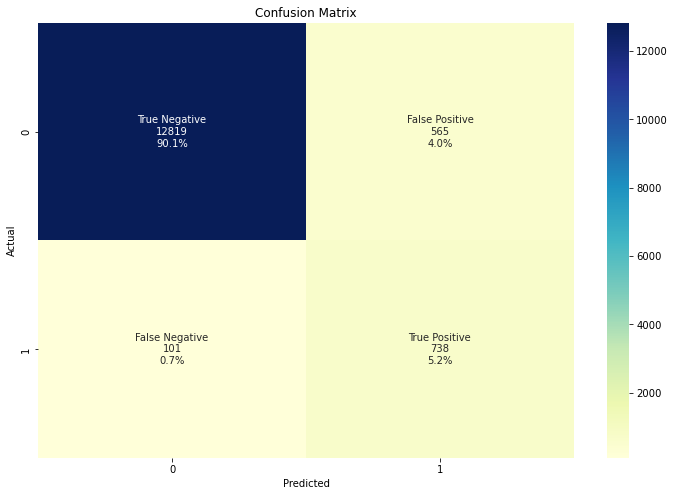

In [13]:
conf_matrix = confusion_matrix(target_test, lgbm_model.predict(features_test))

draw_confusion_matrix(conf_matrix)


**Интерпретация матрицы**

In [14]:
conf_matrix_result(conf_matrix)


Всего предсказаний: 14223
Правильно предсказанные ответы (Accuracy): 0.9532
Ошибки в прогнозах: 0.0468
Recall: 0.8796
Precision: 0.5664
FN/TP: 0.14
FP/TN: 0.04


**PR-кривая**

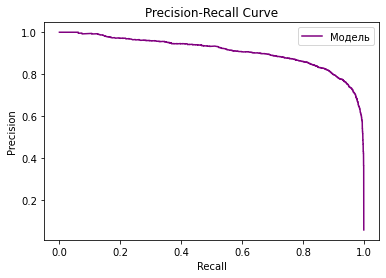

In [15]:
draw_pr_curve(features_train, target_train, lgbm_model, treshold=False)


## Группировка "Оригинал + каверы"

**Client Access Token**

In [16]:
# создание подключения с использованием созданного Client Access Token
genius = lyricsgenius.Genius(
    "PNUx_CdY0pyHpnWJL6QAyp6vdB3tsQYLlXRHX_tR8YvC49rKr2w3OepkaF7oscT-",
    timeout=600,
)

**Инициализация модели**

In [17]:
model = SentenceTransformer(MODEL_PATH)


**Загрузка эмбеддингов**

In [18]:
with open(PROCESSED_DATA_PATH + "embedding_all_texts.pickle", "rb") as file:
    embedding_all_texts = pickle.load(file)


**Группируем оригинал и каверы с помощью `search_covers`**

В имеющейся базе данных найдено 5 трека(ов).
Поиск имён исполнителей осуществлялся по коду isrc на musicbrainzngs.
К сожалению не все коды есть в базе сайта...

Трек 1: Код isrc - GBF089190020, Название - Nothing Else Matters, Исполнитель - Metallica
Тип песни - ORIGINAL, Тип предсказанный моделью - COVER
Модель ошибочно классифицировала тип трека.

Трек 2: Код isrc - QMKHM1900102, Название - Nothing Else Matters, Исполнитель - Metallica
Тип песни - ORIGINAL, Тип предсказанный моделью - ORIGINAL
Модель правильно классифицировала тип трека.

Трек 3: Код isrc - USA560693025, Название - Nothing Else Matters, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 4: Код isrc - USA370581399, Название - Nothing Else Matters, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 5: Код isrc - QMKHM2100037, Название - Nothing Else Matters, Исполнитель -

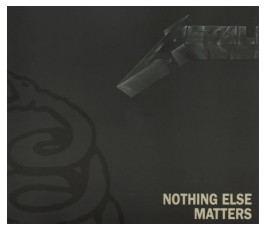

К сожалению не все треки и изображения можно найти на сате https://genius.com


In [19]:
output_data = search_covers(
    song_name="Nothing Else Matters",
    embedding_all_texts=embedding_all_texts,
    device=device,
    model_trasformer=model,
    model_predictor=lgbm_model,
    dataset=processed_data,
)

**Вот так будет выглядеть `output.csv`**

In [20]:
output_data


,isrc,title,genres,year,track_remake_type,track_remake_type_preds,artist
0,GBF089190020,Nothing Else Matters,"CLASSICMETAL, METAL",1991,ORIGINAL,COVER,Metallica
1,QMKHM1900102,Nothing Else Matters,"CLASSICMETAL, METAL",2019,ORIGINAL,ORIGINAL,Metallica
2,USA560693025,Nothing Else Matters,METAL,2006,COVER,COVER,Unknown
3,USA370581399,Nothing Else Matters,ELECTRONICS,2005,COVER,COVER,Unknown
4,QMKHM2100037,Nothing Else Matters,POP,2021,COVER,COVER,Miley Cyrus


**Сохраняем результат**

In [21]:
output_data.to_csv(OUTPUT_PATH + "output.csv")